In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
from glob import glob
import functools
import _pickle as pickle
import sklearn
import sklearn.svm
from sklearn import metrics
from sklearn.preprocessing import binarize

# display plots in this notebook
%matplotlib inline


### Set up plot attribute

In [2]:
# set display defaults
plt.rcParams['figure.figsize'] = (5, 5)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

### Import caffe package

In [3]:
# The caffe module needs to be on the Python path;
# we'll add it here explicitly.
caffe_root = '/opt/caffe'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

### Create Net instance

In [4]:
caffe.set_mode_cpu()

model_def = caffe_root + '/models/bvlc_googlenet/deploy.prototxt'
model_weights = caffe_root + '/models/bvlc_googlenet/bvlc_googlenet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

### Set up input image transformer

In [5]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + '/python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print("mu:", mu)
print('mean-subtracted values:', zip('BGR', mu))

# create transformer for the input called 'data'
# transformer see: https://github.com/BVLC/caffe/blob/master/python/caffe/io.py
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension(变换image矩阵，把channel放到最后一维)
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255](从[0,1]rescale到[0,255])
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR(调整 channels from RGB to BGR)

mu: [ 104.00698793  116.66876762  122.67891434]
mean-subtracted values: <zip object at 0x7f3d85928f88>


### Reshape input data

In [6]:
# set the size of the input (we can skip this if we're happy
# with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          224, 224)  # image size is 227x227

### Feature extraction function

In [7]:
def extract_model_feature(folder_path):
    imgs_path = sorted(glob(folder_path + "/img_*.jpg"))

    img_features = []

    for idx, path in enumerate(imgs_path):
        print(idx)
        #load image see: https://github.com/BVLC/caffe/blob/master/python/caffe/io.py
        img = caffe.io.load_image(path)
        transformed_img = transformer.preprocess("data", img)
        # copy the image data into the memory allocated for the net
        net.blobs['data'].data[...] = transformed_img
        # perform classification
        # 这里output是Net最后一层的输出向量
        output = net.forward()
        # 读取 pool5/7x7_s1 层的特征    
        feature = net.blobs['pool5/7x7_s1'].data[0]
        # 進行標準化，將結果都轉為機率
        feature_standarlized = (feature - min(feature)) / (max(feature) - min(feature))
        print(feature_standarlized.shape)

        # 原feature的shape為(1024, 1, 1)，reshape成(1, 1024)
        reshape_feature = feature_standarlized.reshape(1,feature_standarlized.size) 
        # 此處的reshape_feature_list仍為(1, 1024), ex:[[1, 2, 3]]
        reshape_feature_list = reshape_feature.tolist()
        # 將reshape_feature_list降為一維, ex:[1, 2, 3]
        fe = functools.reduce(lambda x,y: x+y, reshape_feature_list) 

        img_features.append(fe)
    
    return imgs_path, img_features

### Category extraction function

In [8]:
def parse_categories(imgs_path, parse_index):
    #imgs_path, ex: /workspace/caffe_image/Googlenet_Raw_Data/img_hat_0
    #               /workspace/caffe_image/Googlenet_Raw_Data/img_other_1
    
    categories = []
    
    for path in imgs_path:
        #parse category name from path
        cate = path[path.index("_", parse_index) + 1:path.rfind("_")]
        categories.append(cate)

    # unique_labels = ["hat", "other"], 
    # indices = [1, 1, 0, 1, 0]
    # unique_labels[indices] = ["hat", "hat", "other", "hat", "other"]
    unique_labels, indices = np.unique(categories, return_inverse=True)
    trans_indices = map(lambda x: 1 if x==0 else 0, indices)
    
    return unique_labels[indices], list(trans_indices)

### Divide data into training data, validation data, testing data

In [ ]:
TRAINING_DATA_FOLDER_PATH = "/workspace/caffe_image/Googlenet_Raw_Data"
VALIDATION_DATA_FOLDER_PATH = "/workspace/caffe_image/Validation_Data"
TESTINGSET_FOLDER_PATH = "/workspace/caffe_image/Testingset_Data"

training_imgs_path, training_imgs_feature = extract_model_feature(TRAINING_DATA_FOLDER_PATH)
validation_imgs_path, validation_imgs_feature = extract_model_feature(VALIDATION_DATA_FOLDER_PATH)
testingset_imgs_path, testingset_imgs_feature = extract_model_feature(TESTINGSET_FOLDER_PATH)

### Dump result into pickle file

In [ ]:
f = open('googlenet_building_features.b', 'wb')
pickle.dump((training_imgs_path, training_imgs_feature), f)
f.close()

training_imgs_path = np.array(training_imgs_path)
training_imgs_feature = np.array(training_imgs_feature)

np.savez_compressed('googlenet_building_features.npz', training_imgs_path=training_imgs_path, training_imgs_feature=training_imgs_feature)

In [ ]:
f = open('validation_building_features.b', 'wb')
pickle.dump((validation_imgs_path, validation_imgs_feature), f)
f.close()

validation_imgs_path = np.array(validation_imgs_path)
validation_imgs_feature = np.array(validation_imgs_feature)

np.savez_compressed('validation_building_features.npz', validation_imgs_path=validation_imgs_path, validation_imgs_feature=validation_imgs_feature)

In [ ]:
f = open('testingset_building_features.b', 'wb')
pickle.dump((testingset_imgs_path, testingset_imgs_feature), f)
f.close()

testingset_imgs_path = np.array(testingset_imgs_path)
testingset_imgs_feature = np.array(testingset_imgs_feature)

np.savez_compressed('testingset_building_features.npz', testingset_imgs_path=testingset_imgs_path, testingset_imgs_feature=testingset_imgs_feature)

### Open result from pickle file

In [9]:
with open("googlenet_building_features.b", "rb") as f:
    training_imgs_path, training_imgs_feature = pickle.load(f)
    f.close()

training_imgs_feature = np.array(training_imgs_feature)

In [10]:
with open("validation_building_features.b", "rb") as f:
    validation_imgs_path, validation_imgs_feature = pickle.load(f)
    f.close()

validation_imgs_feature = np.array(validation_imgs_feature)

In [11]:
with open("testingset_building_features.b", "rb") as f:
    testingset_imgs_path, testingset_imgs_feature = pickle.load(f)
    f.close()

testingset_imgs_feature = np.array(testingset_imgs_feature)

In [12]:
# class 1 for hat, class 0 for other

training_class, training_numeric_class = parse_categories(training_imgs_path, 40)
validation_class, validation_numeric_class = parse_categories(validation_imgs_path, 30)
print("validation class:", validation_class[410:415])
print("validation numeric class:", validation_numeric_class[410:415])

validation class: ['hat' 'hat' 'other' 'other' 'other']
validation numeric class: [1, 1, 0, 0, 0]


### SVM model training

In [13]:
model = sklearn.svm.SVC(kernel="linear", probability=True)
model.fit(training_imgs_feature, training_numeric_class)

# with open('test_trainedsvm.b', 'wb') as f:
#     pickle.dump((model, unique_labels), f)
    
# The number of classes has to be greater than one; got 1
# 因為目前只有 hat 一個類別，所以沒辦法訓練

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Predict result

In [14]:
validation_predict_class = model.predict(validation_imgs_feature)

accurary_rate = metrics.accuracy_score(validation_numeric_class, validation_predict_class)
print("accurary_rate: ", accurary_rate)

accurary_rate:  0.947128532361


In [15]:
confusion = metrics.confusion_matrix(validation_numeric_class, validation_predict_class)

TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print("confusion matrix:")
print(confusion)
print()
print("TP: ", TP)
print("TN: ", TN)
print("FP: ", FP)
print("FN: ", FN)
print()
print("Precision:", metrics.precision_score(validation_numeric_class, validation_predict_class))
print("Recall:", metrics.recall_score(validation_numeric_class, validation_predict_class))


confusion matrix:
[[666  19]
 [ 39 373]]

TP:  373
TN:  666
FP:  19
FN:  39

Precision: 0.951530612245
Recall: 0.905339805825


### ROC curve

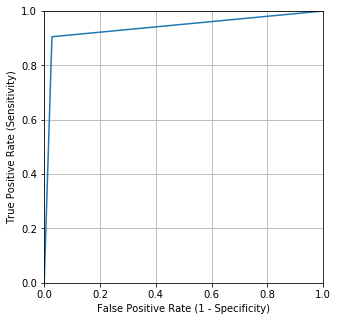

In [16]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities

# roc_curve returns 3 objects fpr, tpr, thresholds
# fpr: false positive rate
# tpr: true positive rate
fpr, tpr, thresholds = metrics.roc_curve(validation_numeric_class, validation_predict_class)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

### Histogram

In [17]:
# fetch the probability of class 1 
validation_predict_prob = model.predict_proba(validation_imgs_feature)[:, 1]
validation_predict_prob

array([ 0.9668645 ,  0.99018396,  0.66651637, ...,  0.01292829,
        0.08024191,  0.04236082])

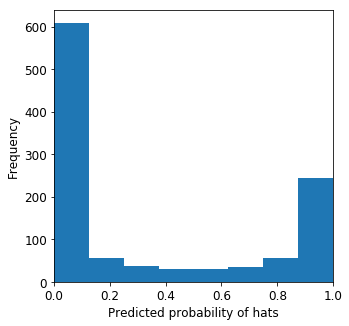

In [18]:
# 8 bins
plt.hist(validation_predict_prob, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.xlabel('Predicted probability of hats')
plt.ylabel('Frequency')

### Predict testing set images

In [19]:
testingset_predict_class = model.predict(testingset_imgs_feature)
testingset_predict_prob = model.predict_proba(testingset_imgs_feature)[:, 1]

296


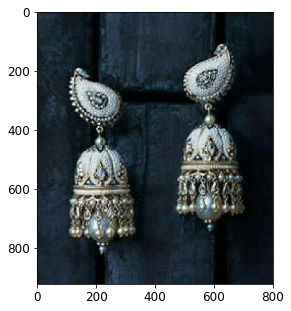

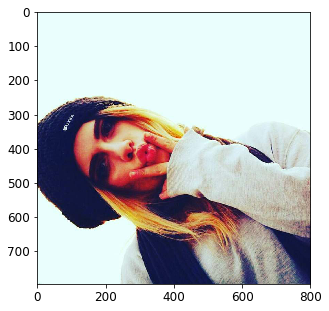

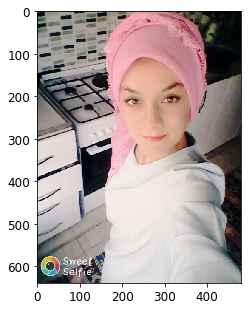

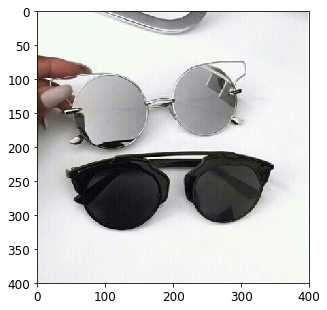

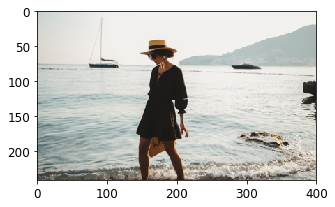

In [20]:
imgs = []

for idx, cate in enumerate(testingset_predict_class):
    if cate == 1:
        imgs.append(testingset_imgs_path[idx])

print(len(imgs))

for path in imgs[10:15]:
    img=mpimg.imread(path)
    plt.figure()
    plt.imshow(img)

### Adjust threshold to increase precision

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


21


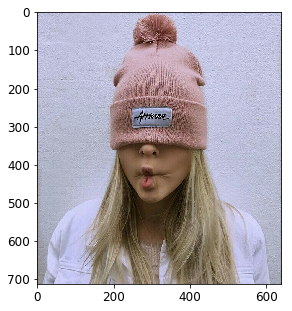

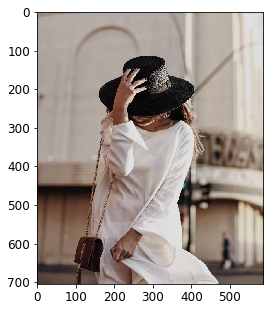

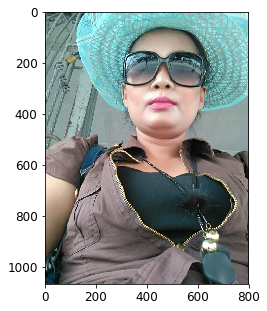

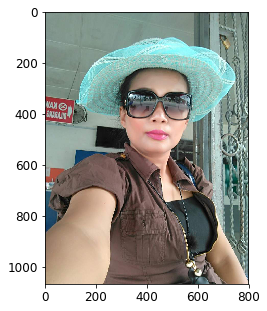

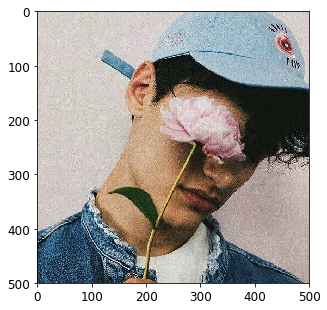

In [21]:
adj_testingset_predict_class = binarize(testingset_predict_prob, 0.95)[0]

imgs = []

for idx, cate in enumerate(adj_testingset_predict_class):
    if cate == 1:
        imgs.append(testingset_imgs_path[idx])

print(len(imgs))

for path in imgs[15:20]:
    img=mpimg.imread(path)
    plt.figure()
    plt.imshow(img)

In [ ]:
# 1.linear-SVM-on-top-of-CNN-example: https://github.com/tmadl/linear-SVM-on-top-of-CNN-example/blob/master/CNNexp.ipynb
# 2.have-fun-with-machine-learning: https://github.com/humphd/have-fun-with-machine-learning/blob/master/README_zh-tw.md
# 3.Solving in Python with LeNet: https://github.com/BVLC/caffe/blob/master/examples/01-learning-lenet.ipynb
# 4.使用pycaffe提取CNN特征: http://www.voidcn.com/article/p-suqkbzmk-bcq.html
# 5.Classification: Instant Recognition with Caffe: http://nbviewer.jupyter.org/github/BVLC/caffe/blob/master/examples/00-classification.ipynb
# 6.Evaluating a Classification Model: http://www.ritchieng.com/machine-learning-evaluate-classification-model/
